In [1]:
!pip install fastai

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
size of test data as compared to train data 49.35%
Average word length of phrases in train is 211.
Average word length of phrases in test is 211.


[Text(0, 0, '0'), Text(0, 0, '1')]

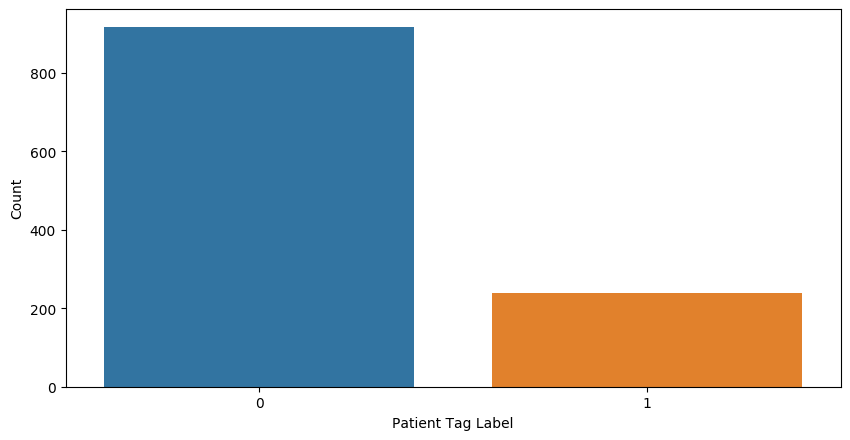

In [19]:
%reload_ext autoreload
%autoreload 2

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#data_preprocessing
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from scipy.stats import randint as sp_randint
from time import time

from textblob import TextBlob
from sklearn.feature_extraction import text
from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from bs4 import BeautifulSoup 
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve

##import dataset
dataset = pd.read_excel('train.xlsx')

##Fill missing values of Host with that link in the same row
for i in list(dataset[dataset['Host'].isnull() == True]['Host'].index):
    dataset.at[i,'Host'] = dataset.loc[i]['Link']
    
##Filling missing value of TRANS_CONV_TEXT with that of title
for i in list(dataset[dataset['TRANS_CONV_TEXT'].isnull() == True].index):
    dataset.at[i, 'TRANS_CONV_TEXT'] = dataset.loc[i]['Title']
##Converting 'Date(ET)' object to datetime
dataset['Date(ET)'] = pd.to_datetime(dataset['Date(ET)'], infer_datetime_format=True)    

##Converting Datetime to timestamp
dataset['Date(ET)'] = dataset[['Date(ET)']].apply(lambda x: x[0].timestamp(), axis = 1).astype(int)

##Dropping time(ET) and time(GMT)
dataset.drop(['Date(ET)', 'Time(ET)', 'time(GMT)'], axis = 1, inplace = True)

##Fill missing values of Title with that of TRANS_CONV_TEXT in the same row
for i in list(dataset[dataset['Title'].isnull() == True]['Title'].index):
    dataset.at[i,'Title'] = dataset.loc[i]['TRANS_CONV_TEXT']

## TEST Data
test = pd.read_csv('test.csv', encoding = 'utf-8')

##Fill missing values of Host with that link in the same row
for i in list(test[test['Host'].isnull() == True]['Host'].index):
    test.at[i,'Host'] = test.loc[i]['Link']
    
#Filling missing value of TRANS_CONV_TEXT with that of title
for i in list(test[test['TRANS_CONV_TEXT'].isnull() == True].index):
    test.at[i, 'TRANS_CONV_TEXT'] = test.loc[i]['Title']

test.at[441,'Date(ET)'] = test.loc[441, 'Time(ET)']

#Converting 'Date(ET)' object to datetime
test['Date(ET)'] = pd.to_datetime(test['Date(ET)'], infer_datetime_format=True)    

#Converting Datetime to timestamp
test['Date(ET)'] = test[['Date(ET)']].apply(lambda x: x[0].timestamp(), axis = 1).astype(int)

#Dropping time(ET) and time(GMT)
test.drop(['Date(ET)','Time(ET)', 'time(GMT)'], axis = 1, inplace = True)

#Fill missing values of Title with that of TRANS_CONV_TEXT in the same row
for i in list(test[test['Title'].isnull() == True]['Title'].index):
    test.at[i,'Title'] = test.loc[i]['TRANS_CONV_TEXT']

index = test['Index']
index = list(index)

test.drop(['Index'], axis = 1, inplace = True)

#feature_selection
y = dataset['Patient_Tag'].tolist()

dataset['Story'] = 'a'


for i in range(len(dataset)):
    dataset.at[i, 'Story'] = dataset['Source'][i] + ' ' + dataset['Host'][i] + ' ' + str(dataset['Link'][i]) + ' ' + dataset['Title'][i] + ' ' + dataset['TRANS_CONV_TEXT'][i]

dataset.drop(['Source', 'Host', 'Link', 'Title', 'TRANS_CONV_TEXT'], axis = 1, inplace = True)


test['Story'] = 'a'


for i in range(len(test)):
    test.at[i, 'Story'] = test['Source'][i] + ' ' + test['Host'][i] + ' ' + str(test['Link'][i]) + ' ' + test['Title'][i] + ' ' + test['TRANS_CONV_TEXT'][i]

test.drop(['Source', 'Host', 'Link', 'Title', 'TRANS_CONV_TEXT', 'Unnamed: 9'], axis = 1, inplace = True)

replace_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def preprocess(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = replace_space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = bad_symbols.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text 

dataset['Story'] = dataset['Story'].apply(preprocess)
test['Story'] = test['Story'].apply(preprocess)

data_train_list = dataset['Story'].tolist()
data_test_list = test['Story'].tolist()

all_data = data_train_list + data_test_list

print("size of test data as compared to train data {:0.2f}%".format(len(test)/len(dataset)*100))

#Returning average word length of phrases for each dataset
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(dataset['Story'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['Story'].apply(lambda x: len(x.split())))))

#Graph
fig, ax = plt.subplots(1,1, dpi = 100, figsize = (10,5))
data_ = pd.read_excel('train.xlsx')
patient_tags_labels = data_['Patient_Tag'].value_counts().index
patient_tags_count = data_['Patient_Tag'].value_counts()

#Plotting
sns.barplot(x = patient_tags_labels, y = patient_tags_count)

ax.set_ylabel('Count')
ax.set_xlabel('Patient Tag Label')
ax.set_xticklabels(patient_tags_labels)

In [3]:
from fastai.text import *

data = (TextList.from_df(dataset, cols = 'Story').split_by_rand_pct(0.2).label_for_lm().databunch(bs = 48))
data.show_batch()







idx,text
0,heart failure due shocking lack knowledge disease area explained conscious misleading patients managed xxunk medical community advocacy groups top xxunk including principal investigator entresto trials publicly expressed concerns xxunk provides xxunk actually happened xxunk strategic marketing team xxunk wrong xxunk model based wrong market assumptions xxunk kept going wrong direction completely xxunk extent xxunk typical example ignorance bias ignorance frequently xxunk confidence knowledge was nt analysts challenging novartis public knows
1,drink problem would nt bad line xxunk led british government world first sugar tax tax come xxunk soft drink five grams sugar per xxunk trouble bbc reports office xxunk responsibility suggests xxunk add xxunk xxunk xxunk xxunk per litre xxunk xxunk xxunk xxunk standard xxunk means red bull xxunk coke around xxunk xxunk per added price serious tax generation policy uk estimates raise 550 million xxunk billion per year extra
2,congestive heart failure that s particularly true cases person unusual shortness breath activity trying sleep also true swelling occurs naturally throughout day tends resolve overnight persistent swelling problematic people constant worsening swelling feet legs see doctor evaluation heart failure symptom 6 indigestion heartburn heartburn indigestion quite common rarely serious instances seemingly benign burning aching xxunk upper abdomen sign heart pain heart attack additionally persistent gastrointestinal distress xxunk xxunk also precursor
3,charity american people virtually every time xxunk man made natural world seems call us assistance rich much offer call usa know come quote originally posted xxunk actually think one wants measure things would hold example good come public assistance 43 diagnosed congestive heart failure caused rare congenital condition isolated left ventricular non xxunk prognosis fairly xxunk 4 5 years heart transplant death time ejection fraction 10 today 5 1 2
4,come xxunk xxunk inhibitors maois category xxunk smoked meats salami smoked salmon chicken liver xxunk problem foods rich xxunk compound caused breakdown amino acid mixed maois cause xxunk levels spike leading dangerously high blood xxunk foods risk list include strong aged cheese smoked processed meats fish xxbos forums wwwicdsupportgrouporg http wwwicdsupportgrouporg board xxunk # xxunk icd actually make feel better effects xxunk situation ef xxunk icd two years day tomorrow


In [4]:
learn = language_model_learner(data, AWD_LSTM, drop_mult = 0.3)

In [5]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,7.368351,6.385512,0.179204,00:08
1,6.690336,5.973965,0.202269,00:08
2,6.158908,5.857986,0.211551,00:08
3,5.851835,5.839256,0.213058,00:08


In [0]:
learn.save('stage-1')


In [0]:
learn.unfreeze()



In [8]:
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,accuracy,time
0,5.648057,5.705765,0.220015,00:10


In [9]:
learn.load('stage-1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (926 items)
x: LMTextList
xxbos forums cafepharmacom http cafepharmacom boards threads xxunk # xxunk epstein do nt disagree principle i m saying entresto major failure novartis commercial organisation novartis totally exposed xxunk call reimbursement issues resolved true underlying problem entresto unveiled novartis failed create demand drug xxunk campaign us drowning man incredibly poor fear xxunk xxunk wrong condition raising awareness lifethreatening acute heart failure instead chronic heart failure entresto indicated entresto nothing treatment acute heart failure due shocking lack knowledge disease area explained conscious misleading patients managed xxunk medical community advocacy groups top xxunk including principal investigator entresto trials publicly expressed concerns xxunk provides xxunk actually happened xxunk strategic marketing team xxunk wrong xxunk model based wrong market assumptions xxunk kept going wrong direct

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


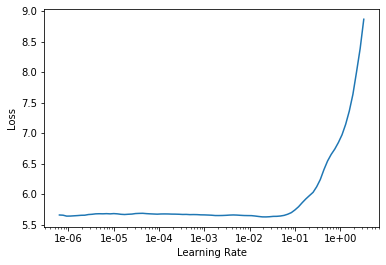

In [11]:
learn.recorder.plot()



In [12]:
learn.unfreeze()
learn.fit_one_cycle(3)



epoch,train_loss,valid_loss,accuracy,time
0,5.617009,5.678671,0.221949,00:10
1,5.289073,5.598900,0.230320,00:11
2,4.860576,5.614086,0.228069,00:11


In [0]:
learn.save_encoder('fine_tuned_enc')


In [14]:
learn.load_encoder('fine_tuned_enc')


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (926 items)
x: LMTextList
xxbos forums cafepharmacom http cafepharmacom boards threads xxunk # xxunk epstein do nt disagree principle i m saying entresto major failure novartis commercial organisation novartis totally exposed xxunk call reimbursement issues resolved true underlying problem entresto unveiled novartis failed create demand drug xxunk campaign us drowning man incredibly poor fear xxunk xxunk wrong condition raising awareness lifethreatening acute heart failure instead chronic heart failure entresto indicated entresto nothing treatment acute heart failure due shocking lack knowledge disease area explained conscious misleading patients managed xxunk medical community advocacy groups top xxunk including principal investigator entresto trials publicly expressed concerns xxunk provides xxunk actually happened xxunk strategic marketing team xxunk wrong xxunk model based wrong market assumptions xxunk kept going wrong direct

In [15]:
learn.predict("the news of the patient is", 50, temperature = 1.1, min_p = 0.001)

'the news of the patient is nt present call anyone concerned get possible medical data mentioned show signs blood pressure however good health could drop due high blood pressure would nt hear doctor told ambulance could know stopped experiencing asthma rapid blood vessels pulmonary edema left ventricle leading cause decreased patient vision could cause problems know'

In [18]:
dataset.columns

Index(['Story'], dtype='object')

In [20]:
test_datalist = TextList.from_df(test, cols = 'Story', vocab = data.vocab)

data_clas = (TextList.from_df(dataset, cols = 'Story', vocab = data.vocab).split_by_rand_pct(0.2)
            .label_from_df(cols = 'Patient_Tag')
            .add_test(test_datalist)
            .databunch(bs = 32))

data_clas.show_batch()


text,target
xxbos facebook http facebookcom xxunk http facebookcom xxunk xxunk help please severe xxunk lupus cardiomyopathy every organ fail body ca nt say determined ever fight cancer 2012 severe spinal stenosis neck back plate neck 4 xxunk holding spinal xxunk spinal cord i m supposed go major back surgery xxunk screw put back i ve block colon part removed xxunk lot pain one kidney birth right side get lot bladder kidney,1
xxbos blog http xxunk xxunk http xxunk xxunk xxunk raising vitamin level 40 ng ml may slash cancer risk 67 percent source dr xxunk checked vitamin status lately ideally want maintain vitamin level 40 60 ng ml xxunk based mounting research 40 ng ml appears magic number whole host health benefits xxunk vitamin deficiency linked variety illnesses 1 including heart disease stroke hypertension autoimmune diseases type 1 type 2 diabetes,0
xxbos forums wwwhindawicom http wwwhindawicom journals xxunk 2016 xxunk splitdose polyethylene glycol superior single dose colonoscopy preparation results randomized controlled trial canadian journal gastroenterology xxunk 2016 2016 article i d xxunk 6 pages research article splitdose polyethylene glycol superior single dose colonoscopy preparation results randomized controlled trial 1 division gastroenterology faculty medicine university calgary calgary ab canada 2 xxunk medicine community health sciences university calgary calgary ab canada 3 xxunk,0
xxbos blog http xxunk http xxunk 2016 04 xxunk glycine muscle building brain boosting amino acid benefits entire body glycine xxunk xxunk amino acid benefits entire body may familiar term specifically use glycine every day strengthen body frankly allow work properly amino acid essential many different muscle cognitive metabolic functions helps break transport nutrients like xxunk fat used cells energy process supports strong immune digestive nervous systems human body glycine,0
xxbos blog http quranfruitzblogspotcom http quranfruitzblogspotcom 2016 02 xxunk causes low blood pressure hypo tension blood pressure measurement pressure arteries active resting phases heartbeat heres numbers mean systolic pressure first top number blood pressure reading amount pressure heart xxunk pumping blood arteries rest body diastolic pressure second bottom number blood pressure reading refers amount pressure arteries heart rest beats current guidelines identify normal blood pressure lower 120 80 mm hg,0


In [0]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult = 0.3)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [22]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


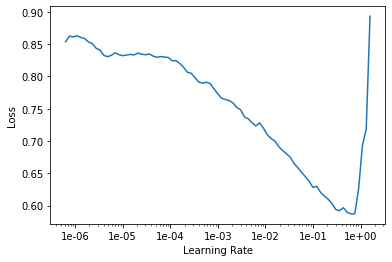

In [23]:
learn_classifier.recorder.plot()

In [24]:
learn_classifier.fit_one_cycle(1, 2e-2, moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.497643,0.314868,0.904762,00:05


In [0]:
learn_classifier.save('first')

In [26]:
learn_classifier.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (926 items)
x: TextList
xxbos forums wwwpatientcouk http wwwpatientcouk forums discuss enlargedheart511396orderlatest # xxunk enlarged heartthread enlarged heart always dizzy get dizzy standing made get slow dizzy turn around turn head slow check blood pressure every day usually around 94 _ 113 65 _ 78 told that s normal england fantastic hospital called xxunk cancer hospital have nt heard hospital hearts monday i m going make mission find one,xxbos blog http abcnewsradioonlinecom xxunk http abcnewsradioonlinecom xxunk xxunk queen latifah xxunk american heart associations red steps campaign xxunk xxunk xxunk new york queen latifah taking matters heart literally xxunk xxunk winner joined forces american heart association red steps campaign idea people post photos taking steps wearing red socks become physically active raise awareness risks symptoms heart failure goal six million red steps recognition nearly six million americans livin

In [27]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.336086,0.229062,0.900433,00:07


In [0]:
learn_classifier.save('second')

In [29]:
learn_classifier.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (926 items)
x: TextList
xxbos forums wwwpatientcouk http wwwpatientcouk forums discuss enlargedheart511396orderlatest # xxunk enlarged heartthread enlarged heart always dizzy get dizzy standing made get slow dizzy turn around turn head slow check blood pressure every day usually around 94 _ 113 65 _ 78 told that s normal england fantastic hospital called xxunk cancer hospital have nt heard hospital hearts monday i m going make mission find one,xxbos blog http abcnewsradioonlinecom xxunk http abcnewsradioonlinecom xxunk xxunk queen latifah xxunk american heart associations red steps campaign xxunk xxunk xxunk new york queen latifah taking matters heart literally xxunk xxunk winner joined forces american heart association red steps campaign idea people post photos taking steps wearing red socks become physically active raise awareness risks symptoms heart failure goal six million red steps recognition nearly six million americans livin

In [30]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3), moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.258051,0.224113,0.909091,00:11


In [0]:
learn_classifier.save('third')

In [32]:
learn_classifier.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (926 items)
x: TextList
xxbos forums wwwpatientcouk http wwwpatientcouk forums discuss enlargedheart511396orderlatest # xxunk enlarged heartthread enlarged heart always dizzy get dizzy standing made get slow dizzy turn around turn head slow check blood pressure every day usually around 94 _ 113 65 _ 78 told that s normal england fantastic hospital called xxunk cancer hospital have nt heard hospital hearts monday i m going make mission find one,xxbos blog http abcnewsradioonlinecom xxunk http abcnewsradioonlinecom xxunk xxunk queen latifah xxunk american heart associations red steps campaign xxunk xxunk xxunk new york queen latifah taking matters heart literally xxunk xxunk winner joined forces american heart association red steps campaign idea people post photos taking steps wearing red socks become physically active raise awareness risks symptoms heart failure goal six million red steps recognition nearly six million americans livin

In [33]:
learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3), moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.170604,0.197048,0.913420,00:14
1,0.145397,0.205786,0.904762,00:13
2,0.122638,0.206326,0.904762,00:13


In [34]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered = True)
labels = np.argmax(preds, axis = 1)

In [35]:
learn_classifier.show_results()

text,target,prediction
xxbos blog xxunk http xxunk heartattack heart attack also known cardiac infarct coronary xxunk coronary thrombosis acute myocardial infarction serious form heart disease common persons suddenly affected drop dead normal activities essential aware symptoms sudden heart attack today modern treatment effective sooner started greater chances complete recovery symptoms heart attack wellestablished underlying causes heart disease welldocumented ways reducing heart attack xxunk wellestablished much research given many answers sensible people follow,0,0
xxbos blog elbiruniblogspotcomblogspotcom http elbiruniblogspotcomblogspotcom 2016 07 xxunk cdc health effects heart disease smoking tobacco use smoking causes one every three deaths cardiovascular disease latest million hearts action steps guide xxunk xxunk provides clinicians tested strategies identifying treating patients use tobacco clinicians try xxunk protocols treating tobacco users xxunk million hearts tobacco xxunk protocol xxunk xxunk xxunk heart disease stroke heart disease stroke cardiovascular heart blood vessel diseases xxunk 1,0,0
xxbos facebook http wwwfacebookcom xxunk http wwwfacebookcom xxunk latvias crocodile harry inspiration hollywood adelaide australia vast xxunk island famous xxunk beautiful outback xxunk populate xxunk xxunk hang trees xxunk flutter skies xxunk xxunk often xxunk quietly reeds ready strike moments notice australias long winding rivers really watch lurking xxunk surface could smiling face deadly crocodile dangers crocodiles well known well known earlier times crocodile xxunk would often become celebrities renowned,0,0
xxbos forums wwwbiospacecom http wwwbiospacecom xxunk sarepta stock collapses fda xxunk vote dmd drug sarepta issues statement advisory committee outcome use eteplirsen treatment duchenne muscular dystrophy cambridge mass business wire sarepta therapeutics inc xxunk developer innovative xxunk therapeutics today announced us food drug administrations fda peripheral central nervous system advisory committee xxunk met review new drug application nda eteplirsen treatment duchenne muscular dystrophy xxunk exon 51 skipping advisory committee voted,0,0
xxbos blog http xxunk http xxunk 2016 04 xxunk pain acute pain xxunk pain management robin xxunk mick xxunk acute pain activation pain receptors sight tissue damage self limiting may worsened associated xxunk stress xxunk controlled acute pain associated development chronic pain optimal pain relief achieved pharmacological non pharmacological measures mindful individual variation response pain need xxunk approach finally decide pain round clock pain relief prn breakthrough summary pharmacological xxunk,0,0


In [0]:
np.save("fastai_prob.npy", preds)

In [39]:
submission = pd.DataFrame()
submission['Index'] = index
submission['Patient_Tag'] = labels
submission.to_csv("fastai_model.csv", index=None)
submission.head()

,Index,Patient_Tag
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0
